In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization,Activation,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers,Sequential

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range=0.4,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   rotation_range=45,
                                   fill_mode='nearest')

In [5]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', 
                                                    batch_size=32, 
                                                    target_size=(120,120), 
                                                    class_mode='categorical',
                                                    shuffle=True, 
                                                    seed = 42, 
                                                    color_mode = 'rgb')

Found 19674 images belonging to 2 classes.


In [8]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', 
                                                   batch_size=32, 
                                                   target_size=(120,120), 
                                                   class_mode='categorical',
                                                   shuffle=False, 
                                                   seed = 42, 
                                                   color_mode = 'rgb')

Found 2158 images belonging to 2 classes.


In [9]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', 
                                                    batch_size=32, 
                                                    target_size=(120,120), 
                                                    class_mode='categorical',
                                                    shuffle=True, 
                                                    seed = 42, 
                                                    color_mode = 'rgb')

Found 2162 images belonging to 2 classes.


In [10]:
x, y = next(train_generator)
print(f"Shape of batch (X): {x.shape}")
print(f"Shape of labels (Y): {y.shape}")


Shape of batch (X): (32, 120, 120, 3)
Shape of labels (Y): (32, 2)


In [11]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.optimizers import Adam

In [12]:
inception_resnet=tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(120,120,3),
    pooling="avg",
)

In [13]:
for layer in inception_resnet.layers:
    layer.trainable = False

model_2 = Sequential()
model_2.add(inception_resnet)
model_2.add(Flatten())
model_2.add(Dropout(0.3))
model_2.add(Dense(256, activation="relu",kernel_initializer='he_uniform'))  # For binary classification
model_2.add(Dropout(0.3))
model_2.add(Dense(2, activation='softmax'))


model_2.build((None,120,120,3))
# Print the model summary
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 1536)                │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,730,722 (208.78 MB)

 Trainable params: 393,986 (1.50 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [14]:
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Smaller learning rate for transfer learning
    metrics=['accuracy', 'AUC']
)

In [15]:
checkpoint = ModelCheckpoint('model_incepresnet.keras', 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=6,
                          mode='auto',
                          verbose=1)

In [16]:
history_03=model_2.fit(train_generator,
                    batch_size=32,
                    steps_per_epoch=60,
                    epochs=10,
                    validation_data=valid_generator,
                    callbacks=[checkpoint,earlystop]
                   )

Epoch 1/10


C:\Users\abhi2\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - AUC: 0.5589 - accuracy: 0.5445 - loss: 1.6875
Epoch 1: val_accuracy improved from -inf to 0.78076, saving model to model_incepresnet.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 57s 711ms/step - AUC: 0.5604 - accuracy: 0.5456 - loss: 1.6807 - val_AUC: 0.8478 - val_accuracy: 0.7808 - val_loss: 0.5440
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - AUC: 0.7773 - accuracy: 0.7137 - loss: 0.8223
Epoch 2: val_accuracy improved from 0.78076 to 0.80250, saving model to model_incepresnet.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 631ms/step - AUC: 0.7775 - accuracy: 0.7139 - loss: 0.8216 - val_AUC: 0.8782 - val_accuracy: 0.8025 - val_loss: 0.4771
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - AUC: 0.8295 - accuracy: 0.7453 - loss: 0.6366
Epoch 3: val_accuracy improved from 0.80250 to 0.81869, saving model to model_incepresnet.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 627ms/step - AUC: 0.8296 - accuracy: 0.7454 - loss: 0.6363 - val_AUC: 0.8948 - val_accuracy: 0.

In [17]:
def plot_metrics(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

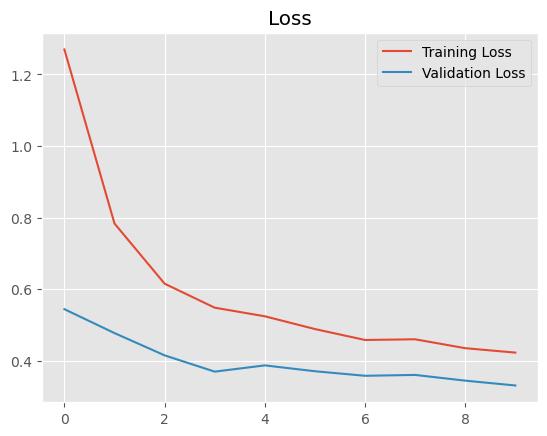

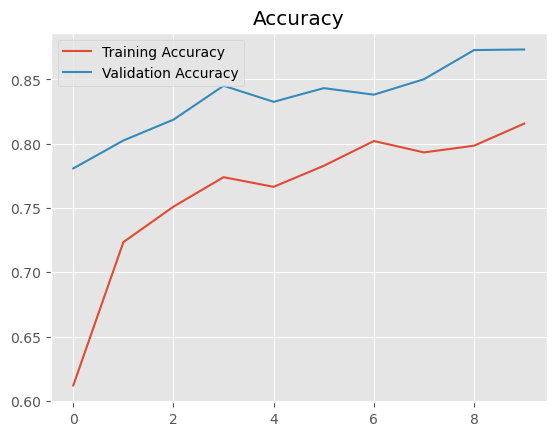

In [18]:
plot_metrics(history_03) 

In [20]:
inception_resnet=tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(120,120,3),
    pooling="avg",
)

for layer in inception_resnet.layers:
    layer.trainable = False

for layer in inception_resnet.layers:
    if layer.name.startswith("block8") or layer.name.startswith("conv_7b") :
        layer.trainable = True

for layer in inception_resnet.layers:
    print(f"{layer.name}: Trainable = {layer.trainable}")

model_2 = Sequential()
model_2.add(inception_resnet)
model_2.add(Flatten())
model_2.add(Dropout(0.3))
model_2.add(Dense(256, activation="relu",kernel_initializer='he_uniform'))  # For binary classification
model_2.add(Dropout(0.3))
model_2.add(Dense(2, activation='softmax'))
# Print the model summary
model_2.build((None,120,120,3))
model_2.summary()

input_layer_3: Trainable = False
conv2d_406: Trainable = False
batch_normalization_406: Trainable = False
activation_406: Trainable = False
conv2d_407: Trainable = False
batch_normalization_407: Trainable = False
activation_407: Trainable = False
conv2d_408: Trainable = False
batch_normalization_408: Trainable = False
activation_408: Trainable = False
max_pooling2d_8: Trainable = False
conv2d_409: Trainable = False
batch_normalization_409: Trainable = False
activation_409: Trainable = False
conv2d_410: Trainable = False
batch_normalization_410: Trainable = False
activation_410: Trainable = False
max_pooling2d_9: Trainable = False
conv2d_414: Trainable = False
batch_normalization_414: Trainable = False
activation_414: Trainable = False
conv2d_412: Trainable = False
conv2d_415: Trainable = False
batch_normalization_412: Trainable = False
batch_normalization_415: Trainable = False
activation_412: Trainable = False
activation_415: Trainable = False
average_pooling2d_2: Trainable = False
co

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 1536)                │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,730,722 (208.78 MB)

 Trainable params: 12,929,602 (49.32 MB)

 Non-trainable params: 41,801,120 (159.46 MB)

In [21]:
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Smaller learning rate for transfer learning
    metrics=['accuracy', 'AUC']
)

In [22]:
history_03=model_2.fit(train_generator,
                    batch_size=32,
                    steps_per_epoch=60,
                    epochs=10,
                    validation_data=valid_generator,
                    callbacks=[checkpoint,earlystop]
                   )

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - AUC: 0.7865 - accuracy: 0.7113 - loss: 0.5771
Epoch 1: val_accuracy did not improve from 0.87327
60/60 ━━━━━━━━━━━━━━━━━━━━ 65s 819ms/step - AUC: 0.7880 - accuracy: 0.7127 - loss: 0.5751 - val_AUC: 0.9291 - val_accuracy: 0.8654 - val_loss: 0.4165
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - AUC: 0.9431 - accuracy: 0.8753 - loss: 0.3051
Epoch 2: val_accuracy improved from 0.87327 to 0.92091, saving model to model_incepresnet.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 774ms/step - AUC: 0.9433 - accuracy: 0.8755 - loss: 0.3046 - val_AUC: 0.9717 - val_accuracy: 0.9209 - val_loss: 0.2231
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - AUC: 0.9733 - accuracy: 0.9157 - loss: 0.2088
Epoch 3: val_accuracy did not improve from 0.92091
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 726ms/step - AUC: 0.9734 - accuracy: 0.9158 - loss: 0.2086 - val_AUC: 0.9718 - val_accuracy: 0.9167 - val_loss: 0.2214
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step 

In [23]:
def plot_metrics(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

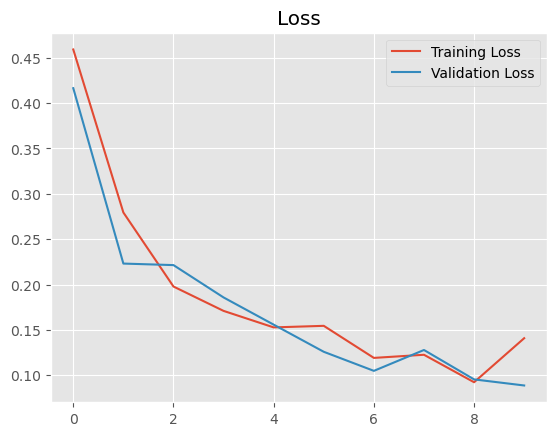

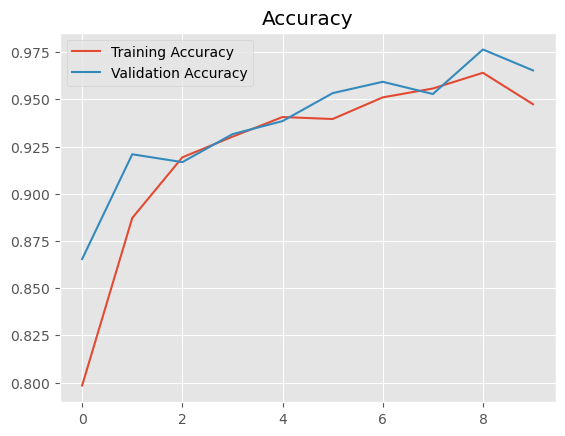

In [24]:
plot_metrics(history_03) 

In [25]:
from tensorflow.keras.models import Model, load_model
model_1=load_model("model_incepresnet.keras")
model_1.metrics_names

['loss', 'compile_metrics']

In [26]:
metrics = model_1.evaluate(test_generator)
loss = metrics[0]
accuracy = metrics[1]
auc = metrics[2]

print(f'Loss: {loss}, Accuracy: {accuracy}, AUC: {auc}')

68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 284ms/step - AUC: 0.9963 - accuracy: 0.9780 - loss: 0.0684
Loss: 0.09282182157039642, Accuracy: 0.9680259227752686, AUC: 0.9944266676902771


In [27]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.09282182157039642
Test Accuracy = 0.9680259227752686


In [28]:
predicted_probabilities = model_1.predict(test_generator)[:, 1]

# Set a custom threshold
threshold = 0.5  # Change this value to experiment
adjusted_predictions = (predicted_probabilities >= threshold).astype(int)

# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_generator.classes, adjusted_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Calculate accuracy, precision, recall, and F1-score
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, adjusted_predictions))

68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step
Confusion Matrix:
 [[1047   32]
 [  34 1045]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1079
           1       0.97      0.97      0.97      1079

    accuracy                           0.97      2158
   macro avg       0.97      0.97      0.97      2158
weighted avg       0.97      0.97      0.97      2158

